### Imports

In [1]:
import chess
import chess.engine
import chess.svg

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import SVG, display

from utils.data_utils import read
from utils.chess_utils import Player, evaluate_all_moves_simple_engine

### Stockfish engine path

In [2]:
engine_path = "engine/stockfish/stockfish-windows-x86-64-avx2.exe"

### Utils

In [3]:
def plot_heuristic_scores(heuristic_scores, optimal_scores, show_all=True, n_shown=10, figsize=(12, 5)):
    '''
    Displays the difference in move scores of heuristic and stockfish player.

    Parameters
    - heuristic_scores (List(float)): List of stockfish evaluations of the heurstic player moves.
    - optimal_scores (List(float)): List of stockfish evaluations of the optimal player moves.
    - show_all (bool): If True, all move scores are displayed. Default: True.
    - n_shown (int): If show_all is False, n_shown move scores are displayed. Default: 10.
    - figsize (Tuple(int,int)): Figure size. Default: (15, 7).
    '''
    fig, ax = plt.subplots()
    
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])

    heuristic_scores = np.array(heuristic_scores)
    optimal_scores = np.array(optimal_scores)
    
    assert len(heuristic_scores) == len(optimal_scores)

    if show_all:
        n_shown = len(heuristic_scores)

    n_shown = n_shown if n_shown <= len(heuristic_scores) else len(heuristic_scores)

    a = ax.bar(range(1, n_shown+1), heuristic_scores[:n_shown], label="heuristic")
    # ax.bar(range(1, n+1), -optimal_scores[:n], label="optimal")
    b = ax.plot(range(1, n_shown+1), optimal_scores[:n_shown], marker="+", linestyle="", color="red", markersize=12, label="optimal")

    ax.set_title("Heuristic vs optimal move stockfish scores")
    ax.legend(loc="upper right", handles=[a, b[0]])
    ax.grid(axis="y")

    ax.set_xlabel("move")
    ax.set_ylabel("score")


def play_stockfish(player, engine_path, player_color=chess.WHITE, display_board=False):
    '''
    Plays a game using the player class object against a stockfish opponent.

    Parameters
    - player (Player): Heuristic player inheriting the Player class.
    - engine_path (str): Path to chess engine.
    - player_color (bool): chess.WHITE or chess.BLACK. Default: chess.WHITE.
    - display_board (bool): If true, displays SVG boards after each heuristic and stockfish opponent move.

    Returns
    - heuristic_scores (List(float)): List of heuristic player move scores.
    - optimal_scores (List(float)): List of stockfish player move scores.
    '''
    board = chess.Board()

    eval_engine = chess.engine.SimpleEngine.popen_uci(engine_path)
    heuristic_scores = []
    optimal_scores = []

    print("Running game...")
    while not player.is_game_over(board):
        if board.turn == player_color:
            # Play optimal stockfish move
            result = eval_engine.play(board, chess.engine.Limit(time=0.1))            
            board.push(result.move)            
            info = eval_engine.analyse(board, chess.engine.Limit(time=0.1))
            optimal_score = info['score'].pov(player_color).score(mate_score=900)
            # print(info['score'].pov(chess.WHITE).score(mate_score=10000))
            # display(SVG(chess.svg.board(board, size=300)))
            board.pop()
            
            move = player.get_best_move(board)
            player.play_move(move, board)
            info = eval_engine.analyse(board, chess.engine.Limit(time=0.1))
            heuristic_score = info['score'].pov(player_color).score(mate_score=900)
            # print(info['score'].pov(chess.WHITE).score(mate_score=10000))

            if display_board:
                display(SVG(chess.svg.board(board, lastmove=move, size=300)))

            # Store scores for plotting
            heuristic_scores.append(heuristic_score)
            optimal_scores.append(optimal_score)

        else:
            # Play optimal stockfish move
            result = eval_engine.play(board, chess.engine.Limit(time=0.1))
            board.push(result.move)
            
            if display_board:
                display(SVG(chess.svg.board(board, lastmove=result.move, size=300)))

    print(f"Winner: {board.outcome().result()}")

    # Close the engines
    eval_engine.quit()

    return heuristic_scores, optimal_scores

## Heuristic 1: Dynamic depth stockfish

Adjust the depth parameter of stockfish based on game state

In [4]:
class HumanHeuristicSimpleStockfish(Player):
    def __init__(self, engine_path, min_depth=1, max_depth=5):
        self.engine = chess.engine.SimpleEngine.popen_uci(engine_path)
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.last_move = None

        print(self.engine)

    def play_move(self, move, board):
        '''
        Play chosen move.

        Parameters
        - move (chess.Move): The move to be played.
        - board (chess.Board): The current state of the chess board.
        '''
        board.push(move)
        self.last_move = move

    def get_best_move(self, board):
        '''
        Get the best move for a given position according to players strategy.

        Parameters
        - board (chess.Board): The current state of the chess board.

        Returns
        - chess.Move: The best move calculated by the engine.
        '''
        # Calculate number of pieces on the board
        num_pieces = len(board.piece_map())
        
        # Determine the depth based on the number of pieces
        if num_pieces > 24:  # Early game, use shallow depth
            depth = self.min_depth
        elif num_pieces > 12:  # Mid game, increase depth
            depth = (self.min_depth + self.max_depth) // 2
        else:  # End game, use maximum depth
            depth = self.max_depth

        # Get the best move from the engine with the determined depth
        result = self.engine.play(board, chess.engine.Limit(time=0.1, depth=depth))
        return result.move

    def is_game_over(self, board):
        '''
        Check if the game is over.

        Parameters
        - board (chess.Board): The current state of the chess board.

        Returns
        - bool: True if the game is over, False otherwise.
        '''
        return board.is_game_over()

    def display_board(self, board, size=300):
        '''
        Display the current state of the chess board.

        Parameters
        - board (chess.Board): The current state of the chess board.
        '''
        if self.last_move:
            svg_board = chess.svg.board(board, lastmove=self.last_move, size=size)
        else:
            svg_board = chess.svg.board(board, size=size)
        display(SVG(svg_board))

    def close_engine(self):
        '''
        Close the chess engine.
        '''
        self.engine.quit()

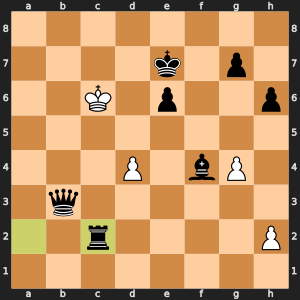

Game over


In [4]:
board = chess.Board()
player = HumanHeuristicSimpleStockfish(engine_path)

while not player.is_game_over(board):
    # player.display_board(board, size=300)
    move = player.get_best_move(board)
    player.play_move(move, board)

player.display_board(board)
print("Game over")
player.close_engine()

In [5]:
player = HumanHeuristicSimpleStockfish(engine_path)
heuristic_scores, optimal_scores = play_stockfish(player, engine_path, chess.WHITE)
player.close_engine()

<SimpleEngine (pid=4108)>
Running game...
Winner: 0-1


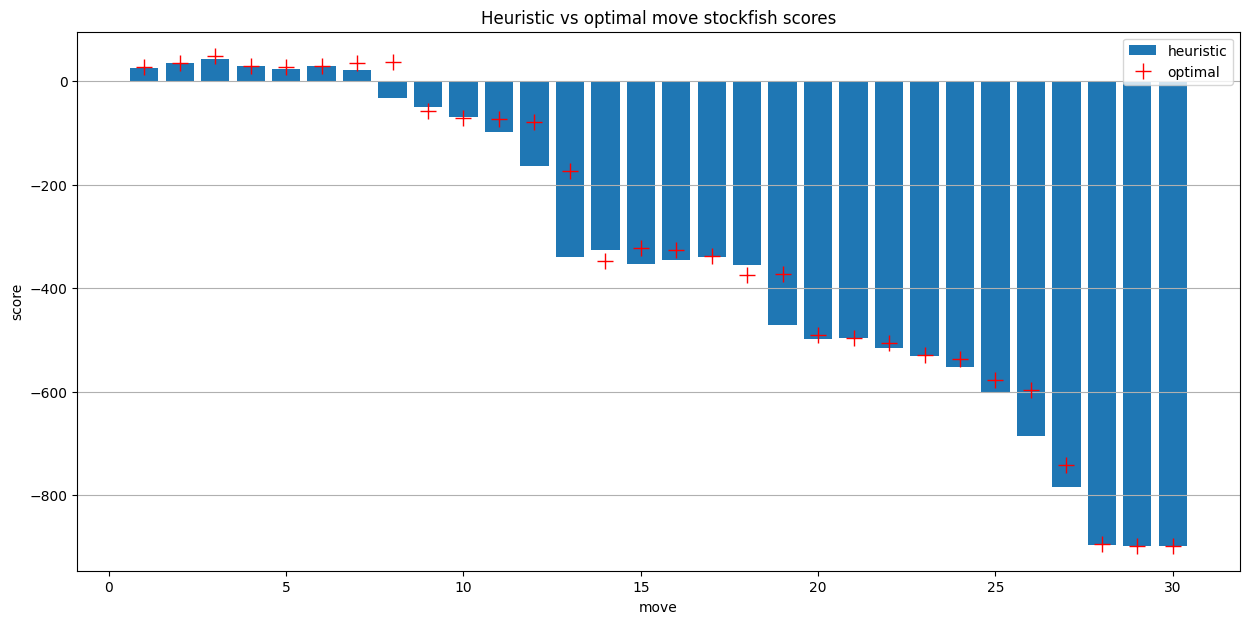

In [6]:
plot_heuristic_scores(heuristic_scores, optimal_scores)

In [14]:
board = chess.Board()
player = HumanHeuristicSimpleStockfish(engine_path, 1, 2)

# Load a separate evaluation engine instance for full-depth analysis
eval_engine = chess.engine.SimpleEngine.popen_uci(engine_path)

white_heuristic_scores = []
white_optimal_scores = []

black_heuristic_scores = []
black_optimal_scores = []

while not player.is_game_over(board):
    # Play optimal stockfish move
    result = eval_engine.play(board, chess.engine.Limit(time=0.1))
    board.push(result.move)
    info = eval_engine.analyse(board, chess.engine.Limit(time=0.1))
    optimal_score = info['score'].pov(board.turn).score(mate_score=10000)
    # print(info['score'].pov(board.turn).score(mate_score=10000))
    # display(SVG(chess.svg.board(board, size=300)))
    board.pop()

    move = player.get_best_move(board)
    player.play_move(move, board)
    info = eval_engine.analyse(board, chess.engine.Limit(time=0.1))
    heuristic_score = info['score'].pov(board.turn).score(mate_score=10000)
    # print(info['score'].pov(board.turn).score(mate_score=10000))
    # display(SVG(chess.svg.board(board, size=300)))
    
    # Store scores for plotting
    if board.turn == chess.WHITE:
        white_heuristic_scores.append(heuristic_score)
        white_optimal_scores.append(optimal_score)

    else:
        black_heuristic_scores.append(heuristic_score)
        black_optimal_scores.append(optimal_score)

print(f"Winner: {board.outcome().result()}")

# Close the engines
player.close_engine()
eval_engine.quit()

Winner: 0-1


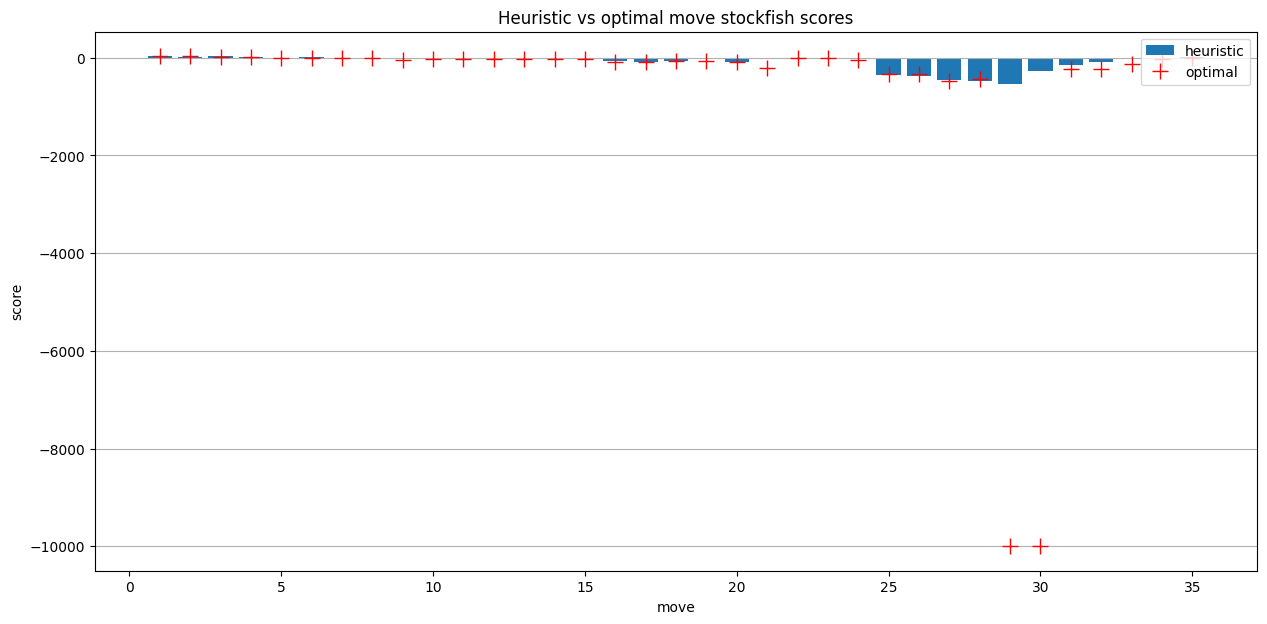

In [15]:
plot_heuristic_scores(white_heuristic_scores, white_optimal_scores, show_all=False, n_shown=35)

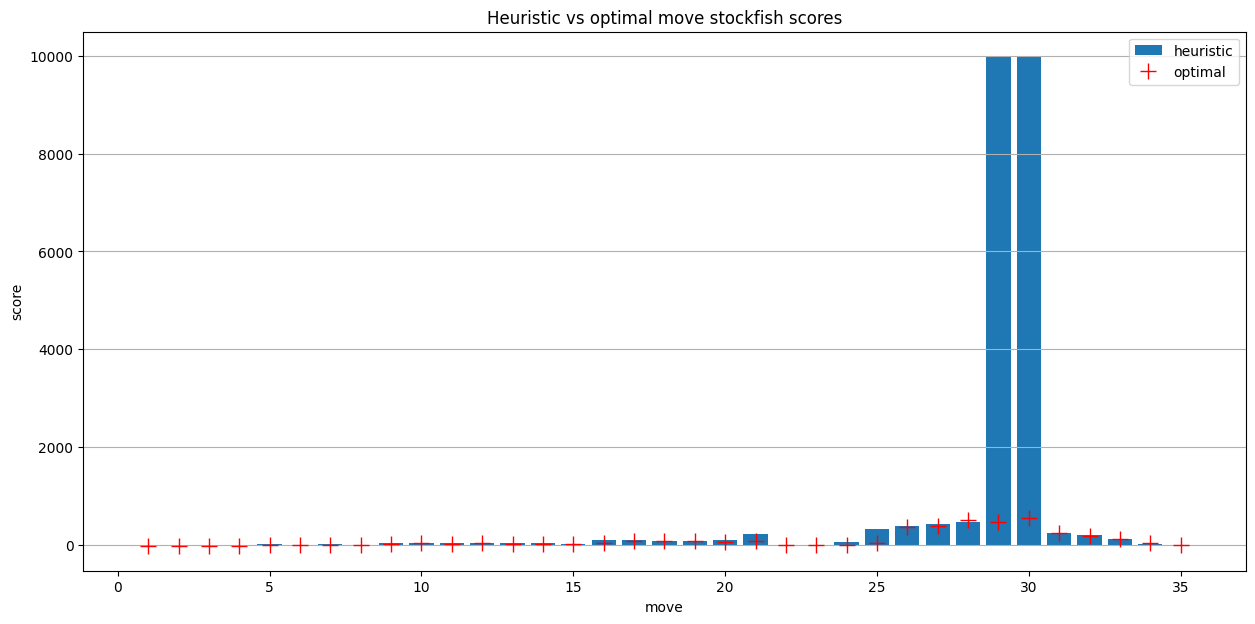

In [16]:
plot_heuristic_scores(black_heuristic_scores, black_optimal_scores, show_all=False, n_shown=35)

## Heuristic 2: Probabilistic stockfish

Use human move quality distribution information to select from all legal moves based on stockfish evaluation (*chess_utils.evaluate_all_moves_simple_engine*) or from *n* multipv moves (*engine.analyse(board, multipv=n)*)

use the position of move e.g. 5th best move out of 20 -> 3/4 quality or the move quality normalized e.g. scores [-10, -5, -3, -2, 0] and move -5 was selected -> 1/2 quality

separate by elo
maybe separate and depending on multipv/all legal

TODO: use a bigger/newer dataset

In [7]:
df = read(data_file = "data\\game_batch_0.npy.gz", column_names_file = "data\\column_names.txt")

# TODO read other dfs and concat

df.shape

(142542, 44)

In [8]:
df = df[df.human == True]
df.shape

(71771, 44)

In [9]:
df.columns

Index(['human', 'player', 'elo', 'color', 'event', 'clock',
       'stockfish_score_depth_1', 'stockfish_difference_depth_1',
       'stockfish_score_depth_2', 'stockfish_difference_depth_2',
       'stockfish_score_depth_3', 'stockfish_difference_depth_3',
       'stockfish_score_depth_4', 'stockfish_difference_depth_4',
       'stockfish_score_depth_5', 'stockfish_difference_depth_5',
       'stockfish_score_depth_8', 'stockfish_difference_depth_8',
       'stockfish_score_depth_10', 'stockfish_difference_depth_10',
       'stockfish_score_depth_12', 'stockfish_difference_depth_12',
       'stockfish_score_depth_15', 'stockfish_difference_depth_15',
       'stockfish_score_depth_16', 'stockfish_difference_depth_16',
       'stockfish_score_depth_18', 'stockfish_difference_depth_18',
       'stockfish_score_depth_20', 'stockfish_difference_depth_20',
       'past_move_1', 'past_move_2', 'past_move_3', 'past_move_4',
       'past_move_5', 'past_move_6', 'past_move_7', 'past_move_8',
  

In [64]:
# df[[x for x in df.columns if "stockfish" in x]]

,stockfish_score_depth_1,stockfish_difference_depth_1,stockfish_score_depth_2,stockfish_difference_depth_2,stockfish_score_depth_3,stockfish_difference_depth_3,stockfish_score_depth_4,stockfish_difference_depth_4,stockfish_score_depth_5,stockfish_difference_depth_5,...,stockfish_score_depth_12,stockfish_difference_depth_12,stockfish_score_depth_15,stockfish_difference_depth_15,stockfish_score_depth_16,stockfish_difference_depth_16,stockfish_score_depth_18,stockfish_difference_depth_18,stockfish_score_depth_20,stockfish_difference_depth_20
1,-45,-15,-45,-17,-45,-15,-39,-12,-41,-14,...,-43,-7,-42,-6,-38,1,-35,10,-46,-1
2,704,-7,704,-7,704,-7,704,-7,704,-7,...,712,71,712,3,703,1,677,-25,744,62
3,-486,-6,-486,-6,-486,-6,-486,-6,-486,-6,...,-519,-45,-496,-14,-504,-32,-474,1,-511,-51
5,110,-143,103,-150,103,-150,103,-150,82,-171,...,175,4,166,-3,160,39,181,71,181,71
7,-283,2,-283,2,-283,10,-283,11,-283,11,...,-339,-34,-397,-118,-371,-110,-366,-83,-411,-128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142529,211,-28,213,-26,213,-26,213,-26,213,-26,...,226,-9,253,27,254,8,165,-73,188,-31
142530,10,-26,2,-57,0,-59,0,-34,-6,-43,...,30,-20,32,-15,32,-5,19,-28,25,-21
142532,41,105,41,105,43,107,43,73,43,11,...,25,-14,30,-14,30,-12,34,-7,33,-8
142534,37,20,37,2,37,2,37,-16,37,-40,...,68,15,63,28,53,20,51,-9,67,30


In [10]:
df = df[["human", "player", "elo", "color", "event", "clock", "current_move_str", "current_move", "past_move_12"]]

In [11]:
df = df.astype({"elo": np.uint16})
df.elo.dtype

dtype('uint16')

In [12]:
df.elo.max(axis=0), df.elo.min(axis=0)

(2500, 857)

In [13]:
def get_elo_container(elo):
    return min(10, max(1, (elo - 1000) // 100 + 1))

df["elo_range"] = df.elo.apply(get_elo_container)
df.elo_range.dtype

dtype('int64')

In [94]:
get_elo_container(1899)

9

In [14]:
print(f"Number of players in elo ranges:")
for i in range(1, 11):
    print(f"{i}: {df[df.elo_range == i].shape[0]}")

Number of players in elo ranges:
1: 1741
2: 2096
3: 3614
4: 6938
5: 7642
6: 8446
7: 9706
8: 9944
9: 8777
10: 12867


In [15]:
df.head(5)

,human,player,elo,color,event,clock,current_move_str,current_move,past_move_12,elo_range
1,True,Pawnbeast,1912,Black,Rated Classical tournament https://lichess.org...,299.0,r1bqkbnr/pp1ppppp/2n5/2p5/4P3/5N2/PPPP1PPP/RNB...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...",10
2,True,mars33,1830,White,Rated Blitz tournament https://lichess.org/tou...,17.0,r7/1p2Np2/p2p2kp/5q2/3p2rP/5Q2/PP5K/4R3 b - - ...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...",9
3,True,guarany9,1725,White,Rated Blitz tournament https://lichess.org/tou...,164.0,r1bq1rk1/pp3ppp/3b4/3Qp3/1P6/P3PN1P/5PP1/R1B1K...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...",8
5,True,MejoDeScarsen,1644,White,Rated Blitz game,244.0,rnbqkbnr/1ppppp2/6p1/p7/2PPP3/2NB3N/PP3PPP/R1B...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...",7
7,True,Argo111,1170,Black,Rated Blitz game,289.0,rnbqk1nr/pp5p/4Ppp1/3B4/1b6/5N2/PPP2PPP/RNBQK2...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...",2


In [16]:
df.columns

Index(['human', 'player', 'elo', 'color', 'event', 'clock', 'current_move_str',
       'current_move', 'past_move_12', 'elo_range'],
      dtype='object')

In [17]:
def bitboard_to_fen(bitboard):
    '''
    Transforms a bitboard back to a FEN representation of a board.

    Parameters
    - bitboard (numpy.ndarray): The current state of the chess board in bitboard representation. 
    The bitboard should contain only the current piece position in the following order: ["p", "r", "n", "b", "q", "k", "P", "R", "N", "B", "Q", "K"]

    Returns
    - str: FEN representation of the board.
    '''

    # Piece symbols for white and black
    pieces =  ["p", "r", "n", "b", "q", "k", "P", "R", "N", "B", "Q", "K"]
    
    # Initialize an empty 8x8 board with empty squares represented by '.'
    board = np.full((8, 8), '.', dtype=str)

    # Fill the board with the pieces based on the bitboard
    for i in range(12):
        piece_positions = bitboard[i]
        piece_symbol = pieces[i]
        for rank in range(8):
            for file in range(8):
                if piece_positions[rank, file] == 1:
                    board[rank, file] = piece_symbol

    # Convert the board to FEN
    fen_rows = []
    for rank in range(8):
        fen_row = ""
        empty_count = 0
        for file in range(8):
            if board[rank, file] == '.':
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += board[rank, file]
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)
    
    fen = "/".join(fen_rows)
    
    return fen

bitboard_to_fen(df.current_move.iloc[0][:12]) == df.current_move_str.iloc[0].split(" ")[0]

True

In [18]:
df.current_move_str.iloc[0], bitboard_to_fen(df.current_move.iloc[0][:12])

('r1bqkbnr/pp1ppppp/2n5/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3',
 'r1bqkbnr/pp1ppppp/2n5/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R')

In [19]:
df["past_move_str"] = df.past_move_12.apply(bitboard_to_fen)

In [20]:
df = df.drop(["past_move_12", "current_move"], axis=1)
df.head(3)

,human,player,elo,color,event,clock,current_move_str,elo_range,past_move_str
1,True,Pawnbeast,1912,Black,Rated Classical tournament https://lichess.org...,299.0,r1bqkbnr/pp1ppppp/2n5/2p5/4P3/5N2/PPPP1PPP/RNB...,10,rnbqkbnr/pp1ppppp/8/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R
2,True,mars33,1830,White,Rated Blitz tournament https://lichess.org/tou...,17.0,r7/1p2Np2/p2p2kp/5q2/3p2rP/5Q2/PP5K/4R3 b - - ...,9,r7/1p3p2/p2p2kp/3N1q2/3p2rP/5Q2/PP5K/4R3
3,True,guarany9,1725,White,Rated Blitz tournament https://lichess.org/tou...,164.0,r1bq1rk1/pp3ppp/3b4/3Qp3/1P6/P3PN1P/5PP1/R1B1K...,8,r1bq1rk1/pp3ppp/3b4/3np3/1P6/P3PN1P/5PP1/R1BQK2R


In [95]:
df.columns

Index(['human', 'player', 'elo', 'color', 'event', 'clock', 'current_move_str',
       'elo_range', 'past_move_str'],
      dtype='object')

True


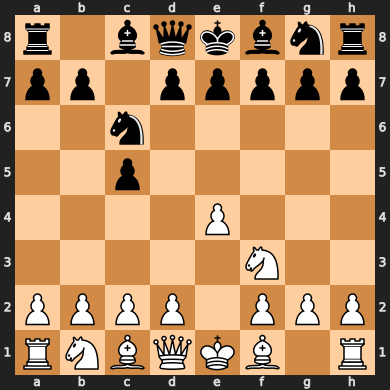

In [85]:
current_board = chess.Board(df.current_move_str.iloc[0])

assert current_board.fen() != chess.STARTING_FEN, "Current board should not be a starting position"

current_board.turn = chess.BLACK if df.iloc[0].color.lower() == "white" else chess.WHITE

print(current_board.turn)
current_board

False


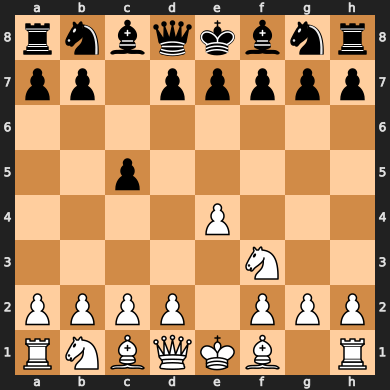

In [21]:
past_board = chess.Board(df.past_move_str.iloc[0])
past_board.turn = chess.WHITE if df.iloc[0].color.lower() == "white" else chess.BLACK

print(past_board.turn)
past_board

In [67]:
eval_engine = chess.engine.SimpleEngine.popen_uci(engine_path)

player_turn = past_board.turn

all_moves = list(past_board.legal_moves)
move_scores = {}
for move in all_moves:
    past_board.push(move)
    info = eval_engine.analyse(past_board, chess.engine.Limit(time=0.1))
    score = info['score'].pov(player_turn).score(mate_score=1000)
    move_scores[move] = score
    if past_board.fen().split(" ")[0] == current_board.fen().split(" ")[0]:
        player_move_score = [move, score]
    past_board.pop()

eval_engine.quit()
move_scores, player_move_score

({Move.from_uci('g8h6'): -106,
  Move.from_uci('g8f6'): -66,
  Move.from_uci('d8c7'): -62,
  Move.from_uci('d8b6'): -93,
  Move.from_uci('d8a5'): -63,
  Move.from_uci('b8c6'): -28,
  Move.from_uci('b8a6'): -112,
  Move.from_uci('h7h6'): -49,
  Move.from_uci('g7g6'): -57,
  Move.from_uci('f7f6'): -131,
  Move.from_uci('e7e6'): -34,
  Move.from_uci('d7d6'): -30,
  Move.from_uci('b7b6'): -63,
  Move.from_uci('a7a6'): -47,
  Move.from_uci('c5c4'): -241,
  Move.from_uci('h7h5'): -73,
  Move.from_uci('g7g5'): -191,
  Move.from_uci('f7f5'): -156,
  Move.from_uci('e7e5'): -183,
  Move.from_uci('d7d5'): -106,
  Move.from_uci('b7b5'): -175,
  Move.from_uci('a7a5'): -169},
 [Move.from_uci('b8c6'), -28])

In [97]:
df["boards"] = df.current_move_str.apply(chess.Board)
df.boards.head(2)

1    r . b q k b n r\np p . p p p p p\n. . n . . . ...
2    r . . . . . . .\n. p . . N p . .\np . . p . . ...
Name: boards, dtype: object

In [98]:
df.shape

(71771, 10)

In [100]:
df[df.current_move_str != chess.STARTING_BOARD_FEN]
df.shape

(71771, 10)

In [68]:
scores = np.fromiter(move_scores.values(), dtype=np.int16)
player_norm_score = (player_move_score[1] - np.min(scores)) / (np.max(scores) - np.min(scores))
player_norm_score

1.0

In [79]:
scores_nodup = list(set(scores))

player_pos_score = None
for i, s in enumerate(sorted(scores_nodup)):
    if s == player_move_score[1]:
        player_pos_score = i/(len(scores_nodup)-1)
        break

player_pos_score

1.0

<BarContainer object of 22 artists>

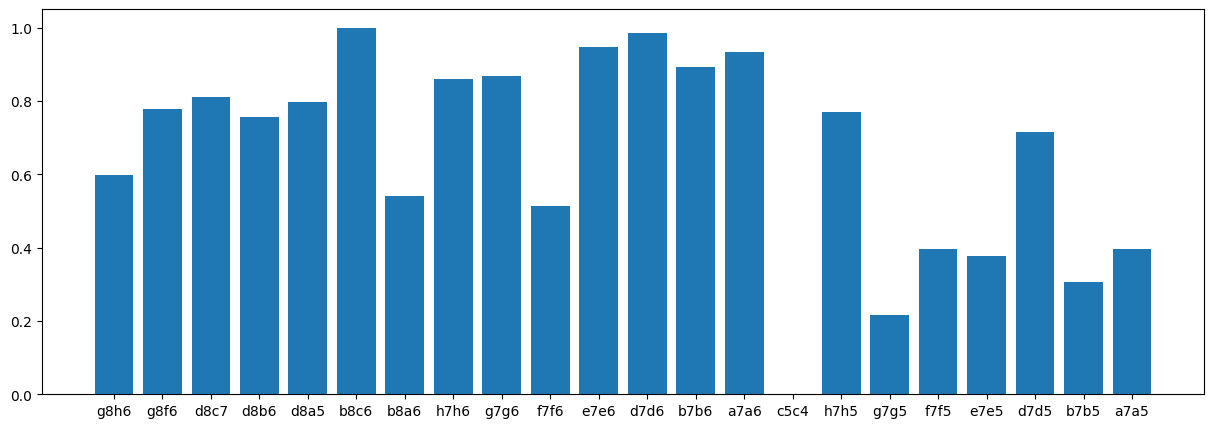

In [52]:
plt.figure(figsize=(15, 5))
norm_scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
plt.bar([x.uci() for x in move_scores.keys()], norm_scores)

In [53]:
norm_scores

array([0.5990991 , 0.77927928, 0.81081081, 0.75675676, 0.7972973 ,
       1.        , 0.54054054, 0.86036036, 0.86936937, 0.51351351,
       0.94594595, 0.98648649, 0.89189189, 0.93243243, 0.        ,
       0.77027027, 0.21621622, 0.3963964 , 0.37837838, 0.71621622,
       0.30630631, 0.3963964 ])

In [ ]:
# TODO break into functions and calculate the results on the dataset

In [39]:
def bitboard_to_fen(bitboard):
    '''
    Transforms a bitboard back to a FEN representation of a board.

    Parameters
    - bitboard (numpy.ndarray): The current state of the chess board in bitboard representation. 
    The bitboard should contain only the current piece position in the following order: ["p", "r", "n", "b", "q", "k", "P", "R", "N", "B", "Q", "K"]

    Returns
    - str: FEN representation of the board.
    '''

    # Piece symbols for white and black
    pieces =  ["p", "r", "n", "b", "q", "k", "P", "R", "N", "B", "Q", "K"]
    
    # Initialize an empty 8x8 board with empty squares represented by '.'
    board = np.full((8, 8), '.', dtype=str)

    # Fill the board with the pieces based on the bitboard
    for i in range(12):
        piece_positions = bitboard[i]
        piece_symbol = pieces[i]
        for rank in range(8):
            for file in range(8):
                if piece_positions[rank, file] == 1:
                    board[rank, file] = piece_symbol

    # Convert the board to FEN
    fen_rows = []
    for rank in range(8):
        fen_row = ""
        empty_count = 0
        for file in range(8):
            if board[rank, file] == '.':
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += board[rank, file]
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)
    
    fen = "/".join(fen_rows)
    
    return fen

def get_elo_container(elo):
    '''
    Contenerizes the player elo.
    <= 1099: 1
    1100-1199: 2
    1200-1299: 3
    ...
    1800-1899: 9
    >= 1900: 10
    '''
    return min(10, max(1, (elo - 1000) // 100 + 1))

def get_human_move_df(df):
    '''
    Returns a dataframe with human current move and past move in fen format.
    
    Columns left: ['elo', 'color', 'event', 'clock', 'current_move_str', 'past_move_str',
       'elo_range']
    '''
    df = df[df.human == True]
    df = df[["human", "player", "elo", "color", "event", "clock", "current_move_str", "current_move", "past_move_12"]]
    df = df.astype({"elo": np.uint16})

    # Apply elo containers
    df["elo_range"] = df.elo.apply(get_elo_container)
    
    df["past_move_str"] = df.past_move_12.apply(bitboard_to_fen)
    df = df.drop(["past_move_12", "current_move", "human", "player"], axis=1)

    # Remove starting positions
    df = df[df.current_move_str != chess.STARTING_FEN]    

    return df

def calculate_move_qualities(human_df, eval_engine, time_limit=0.1):
    '''
    Returns a dataframe with move 'position_score' and 'norm_score' qualities.

    The 'position_score' quality of a move is the position of the move selected by a human player in sorted array 
    of all legal moves ranked by stockfish divided by the length of a set of move scores (range 0.0 - 1.0). 

    The 'norm_score' quality of a move is the normalized stockfish score of the move made by a human player 
    out of all legal moves ranked by stockfish (range 0.0 - 1.0). 
    '''
    eval_engine = chess.engine.SimpleEngine.popen_uci(engine_path)
    
    player_norm_scores = []
    player_pos_scores = []
    for _, row in tqdm(human_df.iterrows()):
        current_board = chess.Board(row.current_move_str)
        past_board = chess.Board(row.past_move_str)
        
        current_board.turn = chess.BLACK if row.color.lower() == "white" else chess.WHITE
        past_board.turn = chess.WHITE if row.color.lower() == "white" else chess.BLACK

        player_turn = past_board.turn
        
        player_move_score = None
        all_moves = list(past_board.legal_moves)
        move_scores = {}
        for move in all_moves:
            past_board.push(move)
            info = eval_engine.analyse(past_board, chess.engine.Limit(time=time_limit))
            score = info['score'].pov(player_turn).score(mate_score=1000)
            move_scores[move] = score
            if past_board.fen().split(" ")[0] == current_board.fen().split(" ")[0]:
                player_move_score = [move, score]
            past_board.pop()

        if player_move_score is None:
            # If player move score is none, we assume castling took place
            # castling cannot be recognized in the reconstructed fen board
            # get player score by analyzing the current board
            info = eval_engine.analyse(current_board, chess.engine.Limit(time=time_limit))
            score = info['score'].pov(player_turn).score(mate_score=1000)
            player_move_score = ["castling", score]
            move_scores["castling"] = score

        assert player_move_score is not None, "Player move should have been found in the legal moves"

        scores = np.fromiter(move_scores.values(), dtype=np.int16)

        if len(scores) == 1:
            player_norm_score = 1.0
        else:    
            player_norm_score = (player_move_score[1] - np.min(scores)) / (np.max(scores) - np.min(scores))
        player_norm_scores.append(player_norm_score)

        scores_nodup = list(set(scores))
        
        player_pos_score = None
        if len(scores_nodup) == 1:
            # Set to 1 if only single score positions available
            player_pos_score = 1.0
        else:
            for i, s in enumerate(sorted(scores_nodup)):
                if s == player_move_score[1]:
                    player_pos_score = i/(len(scores_nodup)-1)
                    break

        player_pos_scores.append(player_pos_score)
    
    eval_engine.quit()

    human_df["position_score"] = player_pos_scores
    human_df["norm_score"] = player_norm_scores

    return human_df

In [6]:
df = read(data_file = "data\\game_batch_0.npy.gz", column_names_file = "data\\column_names.txt")

In [7]:
human_df = get_human_move_df(df)

In [48]:
human_df_scores = calculate_move_qualities(human_df, engine_path, 0.005)

20it [00:03,  5.51it/s]


In [ ]:
## TODO run, get scores and construct the player heuristic based on the statistics

In [59]:
past_board.pop()
past_board.push(chess.Move.from_uci("c5c4"))

eval_engine = chess.engine.SimpleEngine.popen_uci(engine_path)

info = eval_engine.analyse(past_board, chess.engine.Limit(time=0.1))

eval_engine.quit()
info['score'].relative.score()

258

In [19]:
eval_engine = chess.engine.SimpleEngine.popen_uci(engine_path)
board = chess.Board()
info = eval_engine.analyse(board, multipv=10, limit=chess.engine.Limit(time=0.1))
# result = eval_engine.play(board, limit=chess.engine.Limit(time=0.1))
eval_engine.quit()

info

[{'string': 'NNUE evaluation using nn-b1a57edbea57.nnue',
  'depth': 11,
  'seldepth': 17,
  'multipv': 1,
  'score': PovScore(Cp(+25), WHITE),
  'nodes': 123291,
  'nps': 1220702,
  'hashfull': 38,
  'tbhits': 0,
  'time': 0.101,
  'pv': [Move.from_uci('e2e4'),
   Move.from_uci('e7e5'),
   Move.from_uci('g1f3'),
   Move.from_uci('b8c6'),
   Move.from_uci('d2d4'),
   Move.from_uci('e5d4'),
   Move.from_uci('f3d4'),
   Move.from_uci('g8f6'),
   Move.from_uci('b1c3'),
   Move.from_uci('f8b4'),
   Move.from_uci('d4c6'),
   Move.from_uci('b7c6'),
   Move.from_uci('d1d4')]},
 {'depth': 11,
  'seldepth': 17,
  'multipv': 2,
  'score': PovScore(Cp(+25), WHITE),
  'nodes': 123291,
  'nps': 1220702,
  'hashfull': 38,
  'tbhits': 0,
  'time': 0.101,
  'pv': [Move.from_uci('d2d4'),
   Move.from_uci('g8f6'),
   Move.from_uci('c2c4'),
   Move.from_uci('e7e6'),
   Move.from_uci('g1f3'),
   Move.from_uci('d7d5'),
   Move.from_uci('b1c3'),
   Move.from_uci('f8b4'),
   Move.from_uci('c1g5'),
   Move.fr